In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import *

In [1]:
# plt.style.use("dark_background")

In [3]:
train = pd.read_csv('training_set.csv')
meta = pd.read_csv('training_set_metadata.csv')

In [4]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [5]:
symlog = lambda x: np.sign(x) * np.log(np.abs(x))

In [6]:
zscore = lambda x: (x - x.mean()) / x.std()

In [7]:
train_dt = train.groupby(['object_id','passband'])['mjd'].transform(lambda x: x.diff()).fillna(-10)

In [8]:
train['x'] = np.log(1+np.power(train['flux']/train['flux_err'],2))

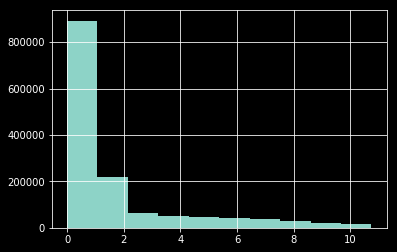

In [9]:
train['x'].hist()

In [10]:
train['x'] = train.groupby(['object_id','passband'])['x'].transform(zscore)

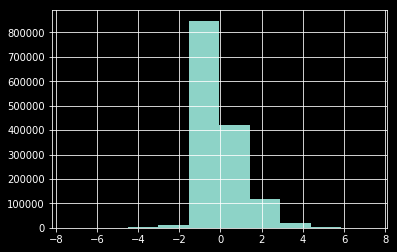

In [11]:
train['x'].hist()

In [12]:
train['dt'] = train_dt

In [13]:
# train['flux'] = train['flux'].apply(symlog)
# train['flux_err'] = train['flux_err'].apply(symlog)

In [14]:
cols_to_drop = ['mjd', 'flux', 'flux_err']

In [15]:
train.drop(cols_to_drop, 1, inplace=True)

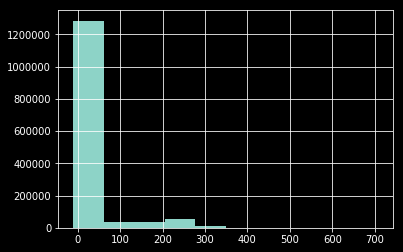

In [16]:
train['dt'].hist()

In [17]:
train['dt'] = train['dt'].apply(lambda x: np.log(1+x) if x > 0 else x)

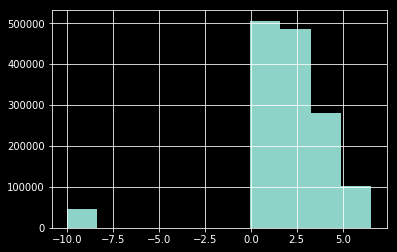

In [18]:
train['dt'].hist()

In [19]:
train.head(30)

,object_id,passband,detected,x,dt
0,615,2,1,0.508180,-10.000000
1,615,1,1,0.557699,-10.000000
2,615,3,1,0.593060,-10.000000
3,615,4,1,-0.923873,-10.000000
4,615,2,1,0.660294,1.093298
5,615,1,1,0.685804,1.093298
6,615,3,1,0.792594,1.093298
7,615,4,1,0.898964,1.094738
8,615,5,1,0.197996,-10.000000
9,615,2,1,0.575854,2.765677


In [20]:
train = train.groupby(['object_id', 'passband']).apply(
    lambda x: x.set_index(['object_id', 'passband']).to_dict(orient='list')
)

In [21]:
train.head(30)

object_id  passband
615        0           {'detected': [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,...
           1           {'detected': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
           2           {'detected': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
           3           {'detected': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
           4           {'detected': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
           5           {'detected': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
713        0           {'detected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
           1           {'detected': [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,...
           2           {'detected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
           3           {'detected': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...
           4           {'detected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
           5           {'detected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
730        0           {'detected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
           1           {'detect

In [22]:
train.to_pickle('train_ts.pkl')

###  Map targets and Class Weighting

In [23]:
ys=sorted(meta['target'].unique())

In [24]:
ys

[6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]

In [25]:
mapping = {v:k for k,v in enumerate(ys)}

In [26]:
pd.to_pickle(mapping, 'target_map.pkl')

In [27]:
meta['target'] = meta['target'].map(mapping)

### Train/CV Split

In [28]:
meta.set_index('object_id', inplace=True)

In [29]:
meta = meta.sample(frac=1.)

In [30]:
p = 0.9

In [31]:
k = int(p*len(meta))

In [32]:
train_ids = meta.iloc[:k].index
cv_ids = meta.iloc[k:].index

In [33]:
len(train_ids)

7063

In [34]:
train_ys = meta['target'].loc[train_ids].values
cv_ys = meta['target'].loc[cv_ids].values

In [35]:
train_ys

array([ 2, 10, 11, ..., 12,  3,  3])

In [36]:
len(train_ys)

7063

In [37]:
len(train_ids)

7063

In [38]:
cv_ids

Int64Index([   121301,      4819,  24531840, 118285479, 119963524,  68270337,
             99179619,  18648923, 102415062,    170667,
            ...
             90432402,  65963501,  13895118,     64896,  35513155,  44469643,
                89455,  99114952,  73569281,     25039],
           dtype='int64', name='object_id', length=785)

In [39]:
train_ids

Int64Index([  5855578,    215351, 129722950,  81886891, 103766729,  40838478,
             27723073,  29586650,  52815591,  48246321,
            ...
            128989049,  22050801,   7412510,    156739,    123211,  97742269,
             51567112,    198690,  83423091,  46026984],
           dtype='int64', name='object_id', length=7063)

In [40]:
train_xs = train.loc[train_ids]
cv_xs = train.loc[cv_ids]

In [41]:
train_xs.to_pickle('train_xs.pkl')
pd.to_pickle(train_ys, 'train_ys.pkl')
cv_xs.to_pickle('cv_xs.pkl')
pd.to_pickle(cv_ys,'cv_ys.pkl')

### Create DataLoaders

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [43]:
class Dset(Dataset):
    
    def __init__(self, data_ids, labels):
        super(Dset, self).__init__()
        self.data_ids = data_ids
        self.labels = labels
        self._len = len(labels)
    
    def __len__(self):
        return self._len
    
    def __getitem__(self, index):
        idx = self.data_ids[index]
        y_i = self.labels[index]
        return idx, y_i

In [44]:
class PassbandDataset(torch.utils.data.Dataset):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys

    def __getitem__(self, i):
        return (self.xs[i], self.ys[i])

    def __len__(self):
        return len(self.xs)

In [47]:
train_xs = pd.read_pickle('train_xs.pkl').unstack('passband')
train_ys = pd.DataFrame(pd.read_pickle('train_ys.pkl'), index=train_xs.index, columns=['y'])
cv_xs = pd.read_pickle('cv_xs.pkl').unstack('passband')
cv_ys = pd.DataFrame(pd.read_pickle('cv_ys.pkl'), index=cv_xs.index, columns=['y'])

In [48]:
def format_sample(x):
    a = [T(np.array(v).astype(np.float32)) for k,v in x.items()]
    a = torch.stack(a)
    a = np.squeeze(a)
    return a

In [49]:
for pb in tqdm(range(6)):
    train_xs[pb] = train_xs[pb].apply(lambda x: format_sample(x))
    cv_xs[pb] = cv_xs[pb].apply(lambda x: format_sample(x))

100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


In [50]:
train_data = pd.concat([train_xs, train_ys], axis=1)
cv_data = pd.concat([cv_xs, cv_ys], axis=1)

In [51]:
train_data.head()

,0,1,2,3,4,5,y
object_id,,,,,,,
615,"[[tensor(0.), tensor(1.), tensor(0.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...","[[tensor(1.), tensor(1.), tensor(1.), tensor(1...",2
713,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(1.), tensor(0.), tensor(1.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",10
730,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",11
745,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",3
1124,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",11


In [52]:
def my_collate(batch):
    data = [item[0:-1] for item in batch]  # just form a list of tensor
    target = [item[-1] for item in batch]
    target = torch.LongTensor(target)
    data = np.squeeze(data)
    return [data, target]

In [53]:
train_set = PassbandDataset(train_xs.values, train_ys.values)
cv_set = PassbandDataset(cv_xs.values, cv_ys.values)

In [54]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, collate_fn=my_collate)
cv_loader = DataLoader(cv_set, batch_size=128, shuffle=False, collate_fn=my_collate)

In [55]:
a = next(iter(train_loader))

In [56]:
data = a[0]

In [57]:
b=a[0][0][0][0]

In [58]:
len(data[0][0])

3

In [59]:
len(data)

128

### Export

In [60]:
torch.save(train_loader, 'train_loader.pt')
torch.save(cv_loader, 'cv_loader.pt')

In [61]:
test = torch.load('train_loader.pt')

In [62]:
a = next(iter(test))

In [63]:
data = a[0]

In [64]:
len(data)

128

In [65]:
len(data[0])

6

In [66]:
data[0][0].shape

torch.Size([3, 14])